In [2]:
import pickle
import matplotlib.pyplot as pl

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

In [43]:
output_dir = '/Users/tgordon/research/exomoons_jwst/JexoSim/output/'
filename = 'OOT_SNR_NIRSpec_BOTS_PRISM_Kepler-1513 b_2020_11_23_1308_49.pickle'
result = pickle.load(open(output_dir + filename, 'rb'))
exp_time = 0.7196
nhours = 40

parts = filename.split('_')
instrument = parts[2]
mode = parts[3]
filt = parts[4]
name = parts[5]
filt_disp = '{0}'.format(filt)

wl = result['noise_dic']['All noise']['wl']
means = result['noise_dic']['All noise']['signal_mean_stack']
stds = result['noise_dic']['All noise']['signal_std_stack']

t = np.arange(0, nhours*60*60, exp_time)

In [33]:
# simulate a time-series representing the covering fraction of the cold photosphere component 

import celerite2
from celerite2 import terms

S0 = 4.4e-12
w0 = 886
term = terms.SHOTerm(S0=S0, w0=w0, Q=1/np.sqrt(2))
gp = celerite2.GaussianProcess(term, mean=0.0)
gp.compute(t/(60*60*24), yerr = 0)
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)

In [34]:
import sys
sys.path.append('./')
import generate_noise
import imp
imp.reload(generate_noise)

factors, data, wl = generate_noise.variability_factors(fk, wl, cold_temp=5500, hot_temp=5600, effective_temp=5500, spec_path='../../JexoSim/archive')

/Users/tgordon/research/exomoons_jwst/notebooks/simulations/generate_noise.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  flux_hot_kep = quad(int_hot_kep, np.min(kep_band[0])/1e3, np.max(kep_band[0])/1e3)
/Users/tgordon/research/exomoons_jwst/notebooks/simulations/generate_noise.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinui

In [35]:
shot_noise = np.random.randn(len(wl), len(t))*stds[:, None]
noisy_lc = means[None, :]*factors.T + shot_noise.T
ppm = (np.sqrt(np.sum(stds ** 2)) / np.sum(means)) / np.sqrt(60 / np.mean(np.diff(t)))

# equal white-noise bins
nbins = 3
total_wn = np.sqrt(np.sum(stds ** 2))
wn_per_bin = total_wn / np.sqrt(nbins)

inds = [0]
j = 0
for i in range(nbins):
    sum_wn_squared = 0
    sum_mean = 0
    while (np.sqrt(sum_wn_squared) < wn_per_bin) & (j < len(stds)):
        sum_wn_squared += stds[j] ** 2
        j += 1
    inds.append(j)

In [36]:
1e6 * (ppm / np.sqrt(int(10.621 * 60 * 60 / np.mean(np.diff(t)))))

0.1816944197899734

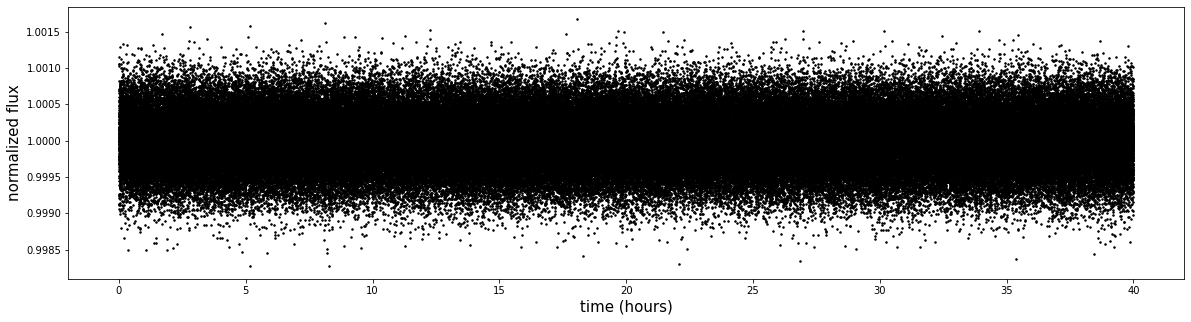

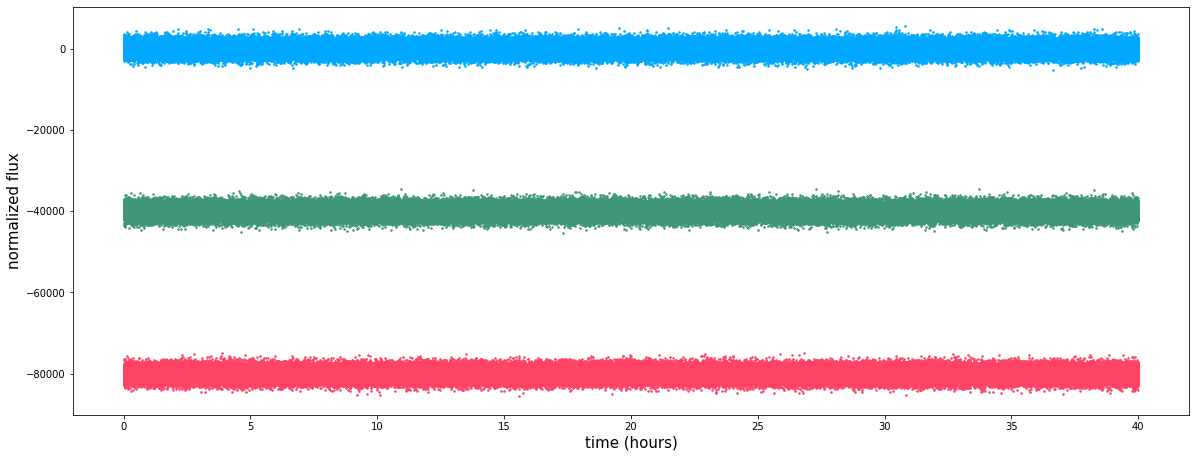

In [37]:
pl.figure(figsize=(20, 5))
monochrome = np.sum(noisy_lc, axis=1)

lcs = np.zeros((len(t), len(inds)-1))
for i in range(len(inds)-1):
    lcs[:, i] = np.sum(noisy_lc[:, inds[i]:inds[i+1]], axis=1)
pl.plot(t/(60*60), monochrome/np.mean(monochrome), 'k.', alpha=1, ms=3)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/monoflux.pdf")

pl.figure(figsize=(20, 7.5))
for i in range(len(inds)-1):
    pl.plot(t/(60*60), lcs[:, i] - np.mean(lcs[:, i]) - 40000 * i, '.', alpha=1, color=colors[2-i], ms=3)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/multiflux.pdf")

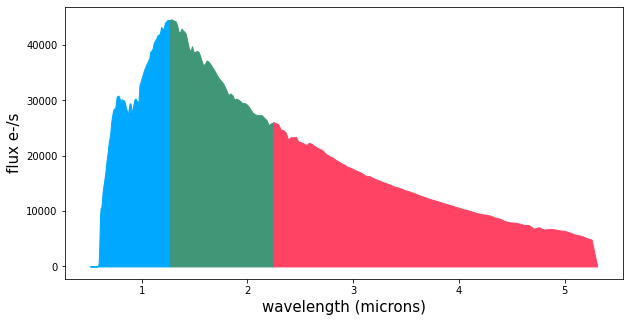

In [38]:
pl.figure(figsize=(10, 5))

for i in range(len(inds)-1):
    pl.fill_between(wl[inds[i]:inds[i+1]+1], means[0:][inds[i]:inds[i+1]+1], color=colors[2-i])
    
pl.xlabel('wavelength (microns)', fontsize=15)
pl.ylabel('flux e-/s', fontsize=15)
pl.savefig("/Users/tgordon/Desktop/spec.pdf")

In [39]:
import exoplanet as xo
orbit = xo.orbits.SimpleTransitOrbit(period=5*60*60, duration=10)
u = [0.3, 0.2]
rp = 0.0203
rm = 0.00378
t0p = 20
t0m = 12
rstar = 0.98
dt = 16
#P = 2*np.pi*
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rp, t=t/(60*60) - t0p, texp=np.mean(np.diff(t))/(60*60))
    .eval()
).T[0]
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rm , t=t/(60*60) - t0m, texp=np.mean(np.diff(t))/(60*60))
    .eval()
).T[0]

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


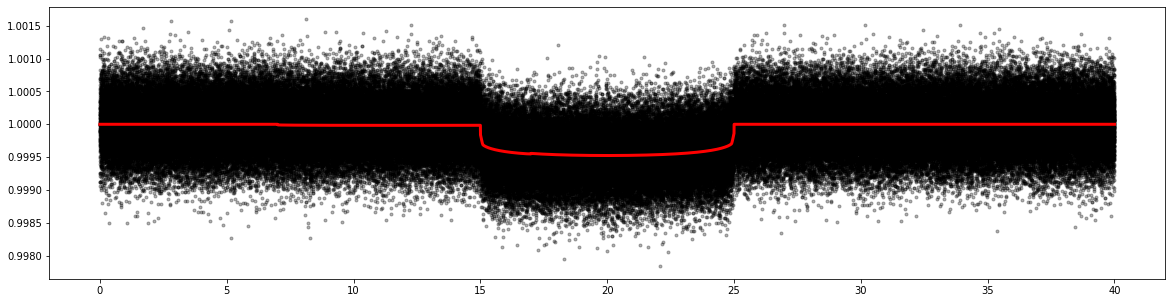

In [40]:
pl.figure(figsize=(20, 5))
pl.plot(t/(60*60), monochrome/np.mean(monochrome) + moon + planet, 'k.', alpha=0.3)
pl.plot(t/(60*60), moon+1+planet, linewidth=3, color='r')

In [41]:
bins = np.linspace(0, 40, 40*2)
binned_nomoon = np.histogram(t/(60*60), bins, weights=monochrome, density=True)[0] / np.histogram(t/(60*60), bins)[0]
binned_moon = np.histogram(t/(60*60), bins, weights=monochrome + moon*np.mean(monochrome), density=True)[0] / np.histogram(t/(60*60), bins)[0]

(9.868766523693329e-06, 9.870129185843198e-06)

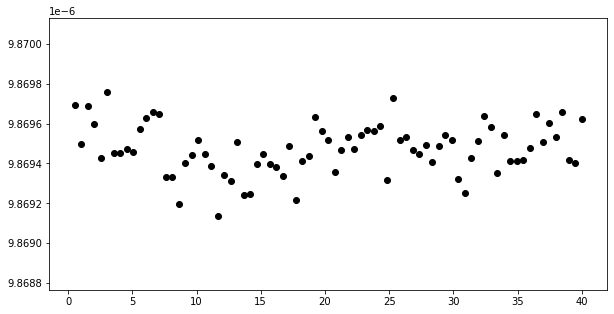

In [42]:
pl.figure(figsize=(10, 5))
#pl.plot(bins[:-1] + np.diff(bins), binned_nomoon, 'ko')
pl.plot(bins[:-1] + np.diff(bins), binned_moon, 'ko')
#pl.plot(t/(60*60), moon*np.mean(binned_moon)+np.mean(binned_moon))
#pl.ylim(np.mean(binned_moon)-1e-9, np.mean(binned_moon)+1e-9)
y0, y1 = pl.ylim()
pl.ylim(y0 - 0.5*(y1-y0), y1 + 0.5*(y1-y0))

(9.868708302096189e-06, 9.870012860571347e-06)

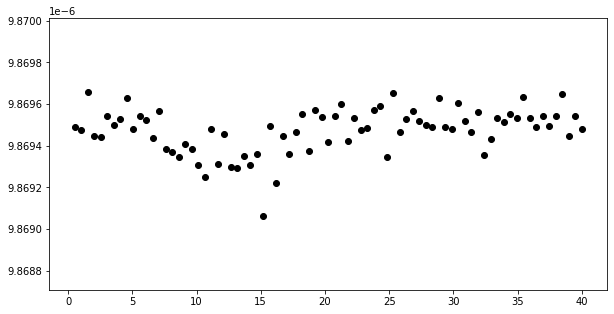

In [32]:
pl.figure(figsize=(10, 5))
#pl.plot(bins[:-1] + np.diff(bins), binned_nomoon, 'ko')
pl.plot(bins[:-1] + np.diff(bins), binned_moon, 'ko')
#pl.plot(t/(60*60), moon*np.mean(binned_moon)+np.mean(binned_moon))
#pl.ylim(np.mean(binned_moon)-1e-9, np.mean(binned_moon)+1e-9)
y0, y1 = pl.ylim()
pl.ylim(y0 - 0.5*(y1-y0), y1 + 0.5*(y1-y0))

In [24]:
from astropy.table import table

data = lcs + np.mean(lcs, axis=0)*(moon[:, None] + planet[:, None])
data = table.QTable(data, names=["wavelength bin {0}".format(i) for i in range(len(data.T))])
data.add_column(t, name='time')
data.meta['name'] = name
data.meta['S0'] = S0
data.meta['w0'] = w0
data.meta['t0p'] = t0p
data.meta['t0m'] = t0m
data.meta['rp'] = rp
data.meta['rm'] = rm
data.meta['rstar'] = rstar
data.meta['noise_floor_ppm'] = ppm
data.meta['filt_disp'] = filt_disp
data.meta['mode'] = mode
data.write(name.replace(' ', "") + ".fits", format='fits', overwrite=True)

In [14]:
name.replace(' ', "") 

'2020'

In [ ]:
int("400")